In [1]:
import torch
from torch import nn
import tqdm
import pytorch_lightning
import matplotlib.pyplot as plt

from torch.distributions import Normal

from case_studies.dc2_mdt.utils.simulate_image import ImageSimulator

In [2]:
image_size = 4
max_objects = 2
image_normalize_strategy = "linear_scale"

In [3]:
class SimpleMLP(nn.Module):
    def __init__(self, layers, hidden_ch):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(image_size * image_size, hidden_ch),
            nn.LayerNorm(hidden_ch),
            nn.ReLU(),
            *[
                nn.Sequential(
                    nn.Linear(hidden_ch, hidden_ch),
                    nn.LayerNorm(hidden_ch),
                    nn.ReLU(),
                ) for _ in range(layers)
            ],
            nn.Linear(hidden_ch, 2)
        )
    
    def forward(self, image):
        x = image.flatten(start_dim=1)
        return self.network(x).chunk(2, dim=-1)
    
    def nll(self, image, true_log_fluxes):
        loc, scale = self(image)
        # scale = torch.ones_like(scale) * 0.05
        return -1 * Normal(loc, scale.abs() + 1e-5).log_prob(true_log_fluxes)
    
    def sample(self, image, sample_size):
        loc, scale = self(image)
        # scale = torch.ones_like(scale) * 0.05
        return Normal(loc, scale.abs() + 1e-5).sample(sample_size)

In [25]:
device = torch.device("cuda:5")
batch_size = 1024
val_batch_size = 100_000
training_iters = 5000
val_iters = 5000
log_freq = 500
seed = 7272
pytorch_lightning.seed_everything(seed)

Seed set to 7272


7272

In [5]:
image_simulator = ImageSimulator(img_height=image_size,
                                 img_width=image_size,
                                 max_objects=max_objects,
                                 min_flux=200.0,
                                 psf_stdev=1.0 if image_size > 1 else 0.1,
                                 background_intensity=100.0).to(device=device)

In [6]:
my_net = SimpleMLP(layers=8, hidden_ch=256).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, milestones=[training_iters // 4 * 3], gamma=0.1)

In [7]:
def encode_flux(flux: torch.Tensor):
    assert flux.min() > 0.0
    return torch.log1p(flux)

def decode_flux(log_flux: torch.Tensor):
    return torch.expm1(log_flux)

In [8]:
my_net.train()
loss_record = []
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size)
    target_fluxes = catalog["fluxes"][:, 0:1]  # (b, 1)
    input_image = catalog["images"].unsqueeze(1)  # (b, 1, h, w)
    match image_normalize_strategy:
        case "none":
            pass
        case "log":
            input_image = torch.log1p(input_image)
        case "linear_scale":
            input_image /= 1000
        case _:
            raise NotImplementedError()
    loss = my_net.nll(input_image, encode_flux(target_fluxes)).mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    my_scheduler.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

 10%|█         | 512/5000 [00:07<01:03, 70.55it/s]

[500/5000] loss: 3.729e-01


 20%|██        | 1010/5000 [00:14<00:55, 71.59it/s]

[1000/5000] loss: -6.649e-01


 30%|███       | 1510/5000 [00:21<00:49, 70.01it/s]

[1500/5000] loss: -1.462e-01


 40%|████      | 2011/5000 [00:28<00:42, 70.92it/s]

[2000/5000] loss: -7.993e-01


 50%|█████     | 2508/5000 [00:35<00:34, 71.21it/s]

[2500/5000] loss: -8.228e-01


 60%|██████    | 3012/5000 [00:42<00:27, 71.16it/s]

[3000/5000] loss: -7.759e-01


 70%|███████   | 3508/5000 [00:49<00:20, 71.42it/s]

[3500/5000] loss: -8.169e-01


 80%|████████  | 4009/5000 [00:56<00:13, 70.91it/s]

[4000/5000] loss: -8.852e-01


 90%|█████████ | 4513/5000 [01:03<00:06, 70.70it/s]

[4500/5000] loss: -9.508e-01


100%|██████████| 5000/5000 [01:10<00:00, 71.14it/s]

[5000/5000] loss: -9.232e-01


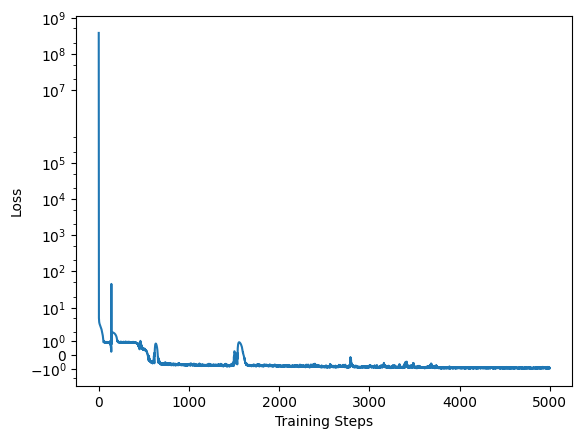

In [9]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("asinh")
plt.show()

In [26]:
my_net.eval()
val_true_fluxes = None
val_est_fluxes = []
with torch.inference_mode():
    val_catalog = image_simulator.generate(batch_size=val_batch_size, 
                                           seed=seed)
    target_fluxes = val_catalog["fluxes"][:, 0:1]  # (b, 1)
    val_true_fluxes = target_fluxes
    input_image = val_catalog["images"].unsqueeze(1)
    match image_normalize_strategy:
        case "none":
            pass
        case "log":
            input_image = torch.log1p(input_image)
        case "linear_scale":
            input_image /= 1000
        case _:
            raise NotImplementedError()
    sample = my_net.sample(input_image, sample_size=[val_iters]).squeeze(0)
    val_est_fluxes = decode_flux(sample).cpu()

In [27]:
val_true_fluxes = val_true_fluxes.cpu()

In [28]:
val_true_fluxes.shape

torch.Size([100000, 1])

In [29]:
val_est_fluxes.shape

torch.Size([5000, 100000, 1])

In [30]:
torch.mean((val_true_fluxes - val_est_fluxes) ** 2)

tensor(20297.2852)

In [31]:
torch.mean(torch.abs(val_true_fluxes - val_est_fluxes))

tensor(108.0533)

In [32]:
val_true_fluxes[:10, 0]

tensor([1775.1583,  262.2697,  734.0314, 1166.0046, 1577.3085,  423.2868,
        1710.9307,  385.5187, 1503.5942, 1495.0698])

In [33]:
val_est_fluxes[0, :10, 0]

tensor([1884.8003,  237.5682, 1037.4789, 1208.6552, 1427.3586,  494.0496,
        1804.9452,  378.6041, 1473.7695, 1311.7190])

In [34]:
# plt.hist(val_est_fluxes.flatten(), color="red", alpha=0.5, density=True)
# plt.hist(val_true_fluxes.flatten(), color="green", alpha=0.5, density=True)
# plt.show()

In [35]:
ci_cover = torch.tensor([i / 100 for i in range(5, 100, 5)])
left_q_points = [(1.0 - c) / 2 for c in ci_cover]
right_q_points = [1.0 - lq for lq in left_q_points]
actual_ci_cover = []
for q in zip(left_q_points, right_q_points):
    q = torch.tensor(q)
    est_fluxes_q = val_est_fluxes.quantile(q=q, dim=0).permute([1, 2, 0])  # (b, 1, 2)
    above_lower_bound = val_true_fluxes[:, 0] > est_fluxes_q[:, 0, 0]
    below_upper_bound = val_true_fluxes[:, 0] < est_fluxes_q[:, 0, 1]
    actual_ci_cover.append((above_lower_bound & below_upper_bound).sum() / val_true_fluxes.shape[0])
actual_ci_cover = torch.stack(actual_ci_cover, dim=0)

In [36]:
actual_ci_cover.shape

torch.Size([19])

In [37]:
actual_ci_cover

tensor([0.0510, 0.1019, 0.1531, 0.2050, 0.2560, 0.3073, 0.3586, 0.4105, 0.4616,
        0.5140, 0.5659, 0.6178, 0.6675, 0.7179, 0.7671, 0.8165, 0.8648, 0.9104,
        0.9535])

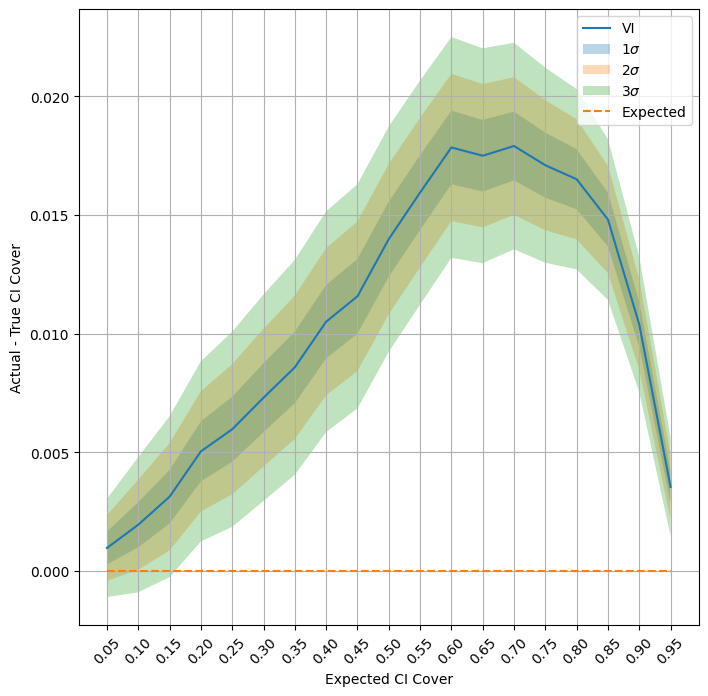

In [55]:
plt.figure(figsize=(8, 8))
a_m_c = actual_ci_cover - ci_cover
ci_sigma = (ci_cover * (1 - ci_cover) / val_batch_size) ** 0.5
plt.plot(ci_cover, a_m_c, label="VI")
plt.fill_between(ci_cover, a_m_c - ci_sigma, a_m_c + ci_sigma, alpha=0.3, label=r"$1\sigma$")
plt.fill_between(ci_cover, a_m_c - 2 * ci_sigma, a_m_c + 2 * ci_sigma, alpha=0.3, label=r"$2\sigma$")
plt.fill_between(ci_cover, a_m_c - 3 * ci_sigma, a_m_c + 3 * ci_sigma, alpha=0.3, label=r"$3\sigma$")
plt.plot(ci_cover, torch.zeros_like(ci_cover), linestyle="dashed", label="Expected")
plt.legend(loc="upper right")
plt.grid()
plt.xticks(ci_cover, rotation=45)
plt.xlabel("Expected CI Cover")
plt.ylabel("Actual - True CI Cover")
plt.show()

In [39]:
q = torch.tensor([0.05, 0.95])
est_fluxes_q = val_est_fluxes.quantile(q=q, dim=0).permute([1, 2, 0])  # (b, 1, 2)

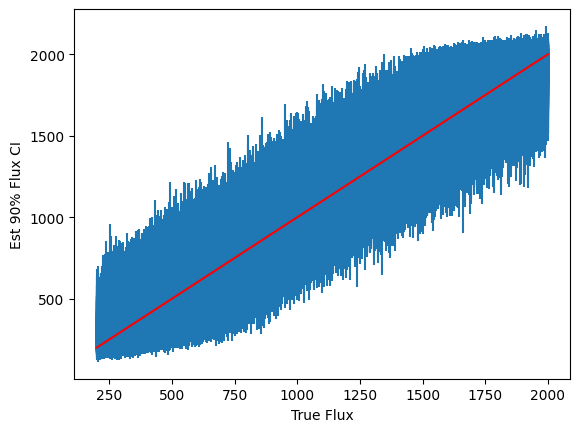

In [40]:
est_fluxes_mean = est_fluxes_q.mean(dim=-1).squeeze(-1)
plt.errorbar(x=val_true_fluxes.flatten(), 
             y=est_fluxes_mean,
             yerr=torch.stack([(est_fluxes_q[:, 0, 0] - est_fluxes_mean).abs(),
                               (est_fluxes_q[:, 0, 1] - est_fluxes_mean).abs()], dim=0),
            fmt="none")
plt.plot([val_true_fluxes.min(), val_true_fluxes.max()], 
         [val_true_fluxes.min(), val_true_fluxes.max()], 
         linestyle="solid", color="red")
plt.xlabel("True Flux")
plt.ylabel("Est 90% Flux CI")
plt.show()